# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [117]:
#imports 
import os
import numpy as np
import time
import random
import copy
from glob import glob
import cv2                
import matplotlib.pyplot as plt    
from tqdm import tqdm
from collections import Counter
from PIL import Image
import torch
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.nn as nn

%matplotlib inline

In [4]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


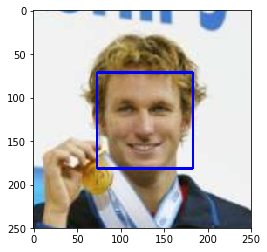

In [5]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [7]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def test_performance(test_data_files, test_function):
    answers_list = []
    for file in test_data_files:
        answers_list.append(test_function(file))
        
    c = Counter(answers_list)
    
    return [(i, c[i] / len(answers_list) * 100.0) for i, count in c.most_common()]
    

In [8]:
print('Predicted human faces on `human_files_short`:', test_performance(human_files_short, face_detector))    
print('Predicted human faces on `dog_files_short`:', test_performance(dog_files_short, face_detector))  

Predicted human faces on `human_files_short`: [(True, 96.0), (False, 4.0)]
Predicted human faces on `dog_files_short`: [(False, 82.0), (True, 18.0)]


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Reference: https://github.com/opencv/opencv/tree/master/samples/dnn/face_detector

modelFile = "./ssd/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "./ssd/deploy.prototxt"

net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def face_detector_dnn (img_path):
    image = cv2.imread(img_path) 
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        return confidence > 0.989

In [10]:
print('Predicted human faces on `human_files_short`:', test_performance(human_files_short, face_detector_dnn))
print('Predicted human faces on `dog_files_short`:', test_performance(dog_files_short, face_detector_dnn))  

Predicted human faces on `human_files_short`: [(True, 99.0), (False, 1.0)]
Predicted human faces on `dog_files_short`: [(False, 92.0), (True, 8.0)]


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# Define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [12]:
loader = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    image_tensor = loader(image).float()  
    image_tensor = image_tensor.unsqueeze(0).to('cuda')

    prediction = VGG16(image_tensor) 
    max_value, max_index = torch.max(prediction,1)
    return max_index.item() # predicted class index

In [13]:
print(VGG16_predict('dogImages/train/007.American_foxhound/American_foxhound_00476.jpg'))

162


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    return 151 <= VGG16_predict(img_path) <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print('Predicted dogs on `human_files_short`:',test_performance(human_files_short, dog_detector))    
print('Predicted dogs on `dog_files_short`:',test_performance(dog_files_short, dog_detector))  

Predicted dogs on `human_files_short`: [(False, 100.0)]
Predicted dogs on `dog_files_short`: [(True, 95.0), (False, 5.0)]


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [16]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# define DENSNET161 model
DN161 = models.densenet161(pretrained=True)
DN161.eval()

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    DN161 = DN161.cuda()

def DN161_predict(img_path):
    image = Image.open(img_path)
    image_tensor = loader(image).to('cuda')
    outputs = DN161(image_tensor.unsqueeze(0)) 
    max_value, max_index = torch.max(outputs,1)
    return max_index.item() 

def dog_detector_RN(img_path):
    ## TODO: Complete the function.
    return DN161_predict(img_path)>=151 and DN161_predict(img_path)<=268

c:\programdata\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [17]:
print('Predicted dogs on `human_files_short`:', test_performance(human_files_short, dog_detector_RN))    
print('Predicted dogs on `dog_files_short`:', test_performance(dog_files_short, dog_detector_RN))  

Predicted dogs on `human_files_short`: [(False, 100.0)]
Predicted dogs on `dog_files_short`: [(True, 98.0), (False, 2.0)]


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [118]:
# Global parameters
num_classes = 133
num_workers = 0
batch_size = 64

In [119]:
#Scratch model parameter
learning_rate_scratch = 0.1
epochs_scratch = 60

In [120]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = "./dogImages/train/"
valid_dir = "./dogImages/valid/"
test_dir = "./dogImages/test/"

# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.Resize(80),
                                       transforms.CenterCrop(80),
                                       transforms.RandomRotation(30),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]) 

valid_transforms = transforms.Compose([transforms.Resize(80),
                                      transforms.CenterCrop(80),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(80),
                                      transforms.CenterCrop(80),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)

loaders_scratch = dict()
loaders_scratch['train'] = torch.utils.data.DataLoader(image_datasets['train'], num_workers=num_workers, batch_size=batch_size, shuffle=True)
loaders_scratch['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], num_workers=num_workers, batch_size=batch_size, shuffle=True)
loaders_scratch['test'] = torch.utils.data.DataLoader(image_datasets['test'], num_workers=num_workers, batch_size=batch_size, shuffle=True)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- Images are resized to 80 by 80 pixels size for the most efficient training time.
- Used random image rotation for train set augmentation because usually images are in different angles.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [121]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.5) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        #print(x.shape)
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
#model_scratch = Net(cfg)
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__   With 5 convolutional layers input image was downsized to 256x2x2 tensor, with selected architecture was possible to train model with 0.1 learning rate while keeping colors with normalization values used in pretrained CNN models. Two fully-connected layers produce final output size and predicts dog breed class. Experiments with different image sizes showed that for this model the most efficient training time could be achieved with 80 by 80 pixels images. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [122]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(params=model_scratch.parameters(), lr=learning_rate_scratch)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [123]:
def train(epochs_scratch, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, epochs_scratch+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss

            output = model(data)
            loss = criterion(output, target)
                        
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            loss_delta = valid_loss_min - valid_loss
            print('Validation loss decreased by {:.6f}\n***Saving best model***'.format(loss_delta))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [124]:
# train the model

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.cuda.empty_cache()

if use_cuda:
    model_scratch = model_scratch.cuda()

model_scratch = train(epochs_scratch, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, './model_scratch.pt')

Epoch: 1 	Training Loss: 4.889911 	Validation Loss: 4.885517
Validation loss decreased by inf
***Saving best model***
Epoch: 2 	Training Loss: 4.880745 	Validation Loss: 4.874066
Validation loss decreased by 0.011451
***Saving best model***
Epoch: 3 	Training Loss: 4.867811 	Validation Loss: 4.859200
Validation loss decreased by 0.014865
***Saving best model***
Epoch: 4 	Training Loss: 4.842642 	Validation Loss: 4.830798
Validation loss decreased by 0.028402
***Saving best model***
Epoch: 5 	Training Loss: 4.774260 	Validation Loss: 4.772588
Validation loss decreased by 0.058210
***Saving best model***
Epoch: 6 	Training Loss: 4.696434 	Validation Loss: 4.670560
Validation loss decreased by 0.102027
***Saving best model***
Epoch: 7 	Training Loss: 4.627074 	Validation Loss: 4.741307
Epoch: 8 	Training Loss: 4.593000 	Validation Loss: 4.574519
Validation loss decreased by 0.096042
***Saving best model***
Epoch: 9 	Training Loss: 4.529919 	Validation Loss: 4.579456
Epoch: 10 	Training Lo

In [125]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [126]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.463445


Test Accuracy: 18% (154/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [75]:
#Transfer model parameters
num_epochs_transfer = 20
learning_rate_transfer = 0.0001

In [76]:
## TODO: Specify data loaders

train_dir = "./dogImages/train/"
valid_dir = "./dogImages/valid/"
test_dir = "./dogImages/test/"

# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)

transfer_loaders = dict()
transfer_loaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], num_workers=num_workers, batch_size=batch_size, shuffle=True)
transfer_loaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], num_workers=num_workers, batch_size=batch_size, shuffle=True)
transfer_loaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], num_workers=num_workers, batch_size=batch_size, shuffle=True)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [77]:
## TODO: Specify model architecture 

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, scheduler, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                #model.train(True) 
                
                model.train()
                for batch_idx, (data, target) in enumerate(loaders[phase]):
                    # move to GPU
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()

                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                
            else:
                ######################    
                # validate the model #
                ######################
                model.eval()
                for batch_idx, (data, target) in enumerate(loaders[phase]):
                    # move to GPU
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()
                    ## update the average validation loss
                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            loss_delta = valid_loss_min - valid_loss
            print('Validation loss decreased by {:.6f}\n***Saving best model***'.format(loss_delta))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [78]:
# Load a pre-trained network
model_transfer = models.resnet152(pretrained=True)

# Freeze parameters to avoid backpropagation
for param in model_transfer.parameters():
    param.requires_grad = False
    
num_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_features, num_classes)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ RESNET152 model was already used for flower classifier (Final Challenge Project in PyTorch Scholarship Challenge). Model showed the best results and I decided to test model performance with different dataset. Hyperparameters were adjusted to reach satisfactory results, implemented `exp_lr_scheduler` helped to optimize learning rate.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [79]:
if use_cuda:
    model_transfer = model_transfer.cuda()

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=learning_rate_transfer)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=5, gamma=1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [80]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train(num_epochs_transfer, transfer_loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, exp_lr_scheduler, 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.377765 	Validation Loss: 3.729879
Validation loss decreased by inf
***Saving best model***
Epoch: 2 	Training Loss: 3.288541 	Validation Loss: 2.752003
Validation loss decreased by 0.977875
***Saving best model***
Epoch: 3 	Training Loss: 2.484277 	Validation Loss: 2.121759
Validation loss decreased by 0.630244
***Saving best model***
Epoch: 4 	Training Loss: 1.924752 	Validation Loss: 1.601530
Validation loss decreased by 0.520230
***Saving best model***
Epoch: 5 	Training Loss: 1.548843 	Validation Loss: 1.395695
Validation loss decreased by 0.205835
***Saving best model***
Epoch: 6 	Training Loss: 1.296687 	Validation Loss: 1.144721
Validation loss decreased by 0.250974
***Saving best model***
Epoch: 7 	Training Loss: 1.125181 	Validation Loss: 1.114784
Validation loss decreased by 0.029936
***Saving best model***
Epoch: 8 	Training Loss: 0.984137 	Validation Loss: 0.901190
Validation loss decreased by 0.213594
***Saving best model***
Epoch: 9 	Training Lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [81]:
test(transfer_loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.546209


Test Accuracy: 86% (725/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [91]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in transfer_loaders['train'].dataset.classes]

class_names = [item for item in transfer_loaders['train'].dataset.classes]

def predict_breed_transfer(img_path, class_names, model):
    image = Image.open(img_path)
    image_tensor = loader(image).to('cuda')
    outputs = model_transfer(image_tensor.unsqueeze(0)) 
    max_value, max_index = torch.max(outputs,1)
    return class_names[max_index.item()]

In [92]:
print (predict_breed_transfer('./dogImages/test/068.Flat-coated_retriever/Flat-coated_retriever_04725.jpg', class_names, model_transfer))

068.Flat-coated_retriever


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [97]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def show_results(img_path, prediction):
    img_input = Image.open(img_path)
    img_input = img_input.resize((300,300), Image.ANTIALIAS)
    if prediction:
        root = './dogImages/train/'+ prediction
        pred_img_list = os.listdir(root)
        example = random.choice(pred_img_list)
        pred_img_path = './dogImages/train/'+ prediction + '/'+ example
        img_pred = Image.open(pred_img_path)
        img_pred = img_pred.resize((300,300), Image.ANTIALIAS)

        print('Input:',img_path)
        display(img_input)
        print('Prediction: ',prediction[4:].replace("_", " "))
        display(img_pred)
    else:
        print('Input:',img_path)
        print("Neither dog or humand was detected.")
        display(img_input)
    print('-' * 37)


def run_app(img_path):
    if dog_detector_RN(img_path):
        pred = predict_breed_transfer(img_path, class_names, model_transfer)
        return show_results(img_path, pred)
    elif face_detector_dnn(img_path):
        prediction = predict_breed_transfer(img_path, class_names, model_transfer)
        return show_results(img_path, prediction)
    else:
        return show_results(img_path, False)    
    ## handle cases for a human face, dog, and neither

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
Output seems good enough, but for better results require:
- More data for training.
- Transfer learning with different retrained models.
- Data pre-processing with different image transformation combinations.

Input: lfw\Steve_Valentine\Steve_Valentine_0001.jpg


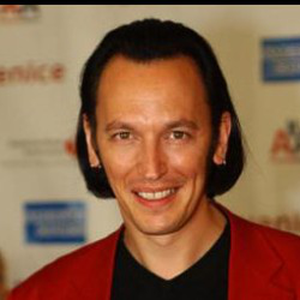

Prediction:  Dachshund


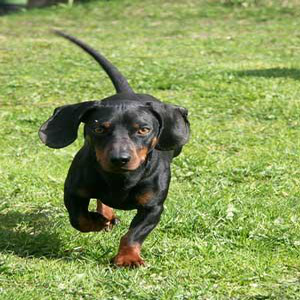

-------------------------------------
Input: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip_Erdogan_0028.jpg


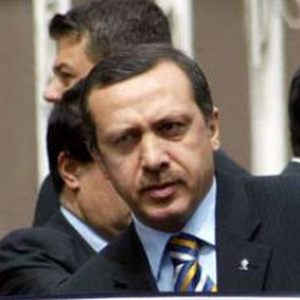

Prediction:  Bearded collie


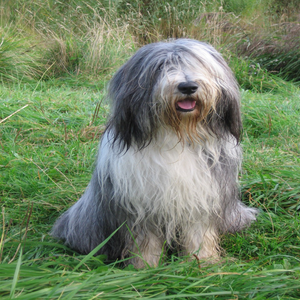

-------------------------------------
Input: lfw\Chang_Sang\Chang_Sang_0001.jpg


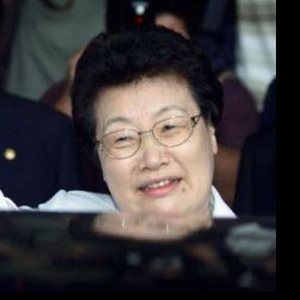

Prediction:  Black russian terrier


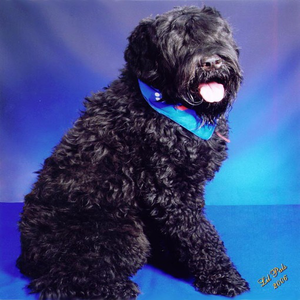

-------------------------------------
Input: dogImages\train\047.Chesapeake_bay_retriever\Chesapeake_bay_retriever_03355.jpg


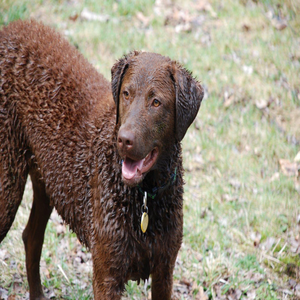

Prediction:  Curly-coated retriever


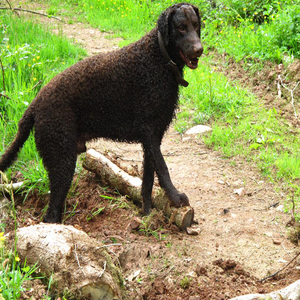

-------------------------------------
Input: dogImages\train\051.Chow_chow\Chow_chow_03653.jpg


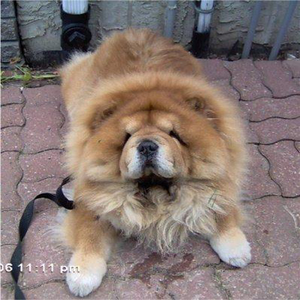

Prediction:  Chow chow


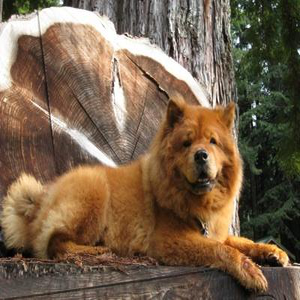

-------------------------------------
Input: dogImages\train\060.Dogue_de_bordeaux\Dogue_de_bordeaux_04273.jpg


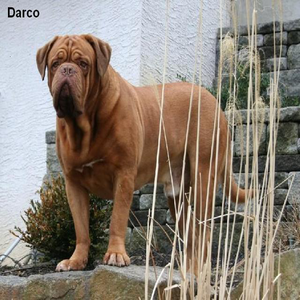

Prediction:  Dogue de bordeaux


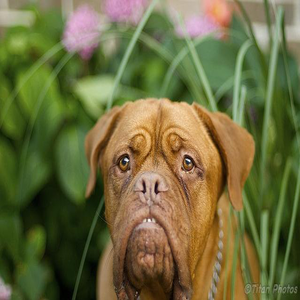

-------------------------------------


In [115]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
# suggested code, below

random.shuffle(human_files)
random.shuffle(dog_files)

for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)
    

Input: ./test_images/Ahmed_Chalabi_0001.jpg


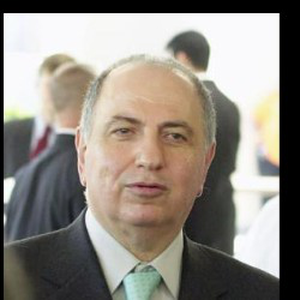

Prediction:  Black russian terrier


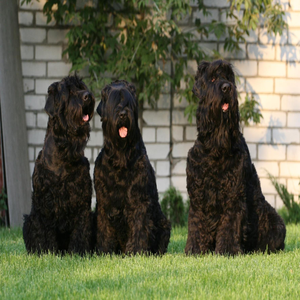

-------------------------------------
Input: ./test_images/car.jpg
Neither dog or humand was detected.


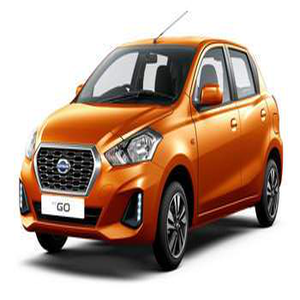

-------------------------------------
Input: ./test_images/Adam_Sandler_0002.jpg


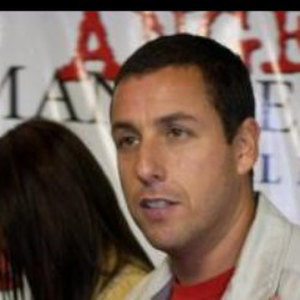

Prediction:  Poodle


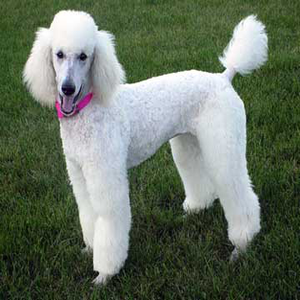

-------------------------------------
Input: ./test_images/English_cocker_spaniel_04347.jpg


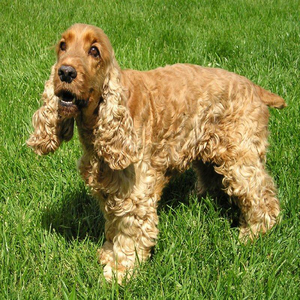

Prediction:  English cocker spaniel


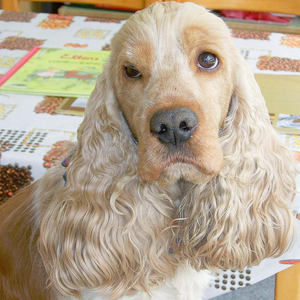

-------------------------------------
Input: ./test_images/Norfolk_terrier_07087.jpg


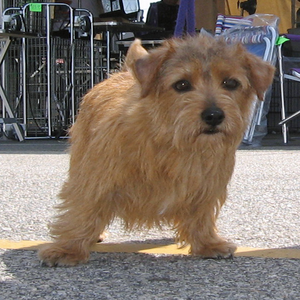

Prediction:  Norfolk terrier


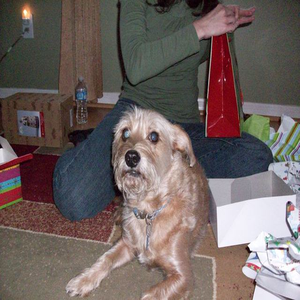

-------------------------------------
Input: ./test_images/Wilson_Alvarez_0001.jpg


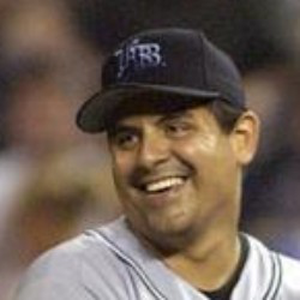

Prediction:  Cane corso


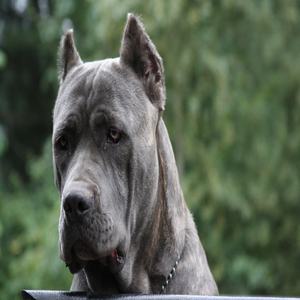

-------------------------------------
Input: ./test_images/Mastiff_06836.jpg


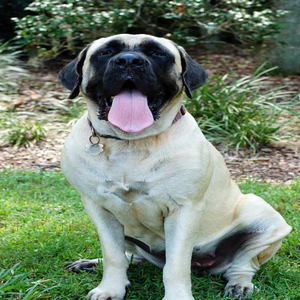

Prediction:  Mastiff


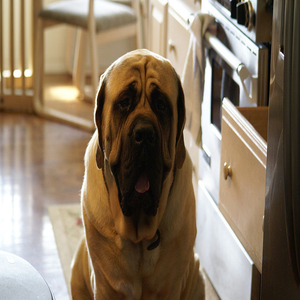

-------------------------------------
Input: ./test_images/bike.jpg
Neither dog or humand was detected.


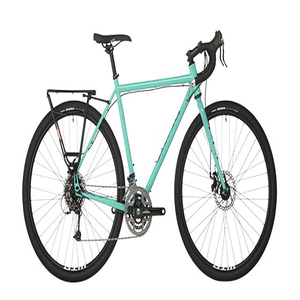

-------------------------------------
Input: ./test_images/cat.jpg
Neither dog or humand was detected.


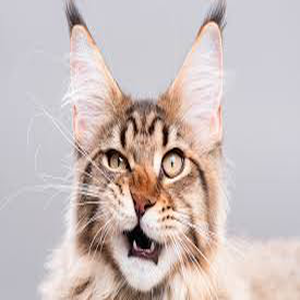

-------------------------------------


In [116]:
root = './test_images/'

test_images = os.listdir(root)

random.shuffle(test_images)

for file in test_images:
    run_app(root + file)